# OLX Case study

The data is sample of listings taken from the south african olx site as well as a list of popular recent keywords on olx.co.za. The ultimate goal is to group similar items into clusters, so that if the items A and B are part of the same cluster it is reasonable to recommend B to a user that is viewing or has viewed A.

There are five main sections in this post:
- Requirements modules.
- Directory structure.
- Expoloratory Data Analysis.
- Modelling.
- Discussion.

# 1. Requirements modules.
Python 2.7
Required libraries:
- numpy
- pandas
- sklearn
- matplotlib
- nltk
- pickle

Hardware used:
- Ubuntu 14.04
- Memory: 16G

# 2. Directory structure.
├── README.md         
├── olx_case_study-v0.ipynb                 <- Script to explore data and train model.        
├── olx_data_sample/za_sample_listings_incl_cat.csv     <- Input data.

# 3. Expoloratory Data Analysis.

In [1]:
#loading libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import numpy as np
import pandas as pd
import nltk
import re
import pickle
import sys
from time import time
from matplotlib import pylab as plt
from nltk.stem.snowball import PorterStemmer,SnowballStemmer
stemmer = PorterStemmer()

In [2]:
#Download nltk tagger
try: 
    print 'Checking nltk tagger model...'
    nltk.data.find("averaged_perceptron_tagger")
except:
    print 'Downloading nltk tager model...'
    nltk.download('averaged_perceptron_tagger')

Checking nltk tagger model...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/quy.nguyen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
#loading data
df  = pd.read_csv('./olx_data_sample/za_sample_listings_incl_cat.csv', index_col = 0)
print df.shape
df.head()


(500016, 11)


/Users/quy.nguyen/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,item_id,seller_id,listing_title,listing_description,listing_price,category_sk,category_l1_name_en,category_l2_name_en,category_l3_name_en,listing_latitude,listing_longitude
0.0,0.0,0,Nice wooden makes,We build all different types for sale,17500.00,olx|mea|za|806|809,"Home, Garden & Tools",Garden & Braai,Unknown,-25.43067,27.84873
1.0,1.0,1,A Shinning 2013 Chevrolet 1.4 Utility Bakkie w...,A Stunning accident free bargain that has just...,94890.00,olx|mea|za|362|378|2012,Vehicles,Cars & Bakkies,Chevrolet,-29.73714,31.07364
2.0,2.0,2,Lampshades various,A variety of lampshades in white,20.00,olx|mea|za|806|807,"Home, Garden & Tools",Furniture & Decor,Unknown,-33.88159,18.55522
3.0,3.0,3,Toyota Corolla,"Toyota Corolla 1.3 Professional, Front Electri...",63995.00,olx|mea|za|362|378|2067,Vehicles,Cars & Bakkies,Toyota,-26.10757,28.05670
4.0,4.0,4,bench grinder and buffer,bench grinder and.buffer...R800 for both,800.00,olx|mea|za|806|910,"Home, Garden & Tools",Tools & DIY,Unknown,-26.17190,27.91318


In [4]:
#Number of categories
print df.category_sk.nunique()
print df.category_l1_name_en.nunique()
print df.category_l2_name_en.nunique()
print df.category_l3_name_en.nunique()

366
23
55
271


In [5]:
df.category_l1_name_en.value_counts()

Vehicles                   222198
Electronics & Computers     74478
Home, Garden & Tools        61722
Services                    28892
Property                    19753
Sports & Outdoors           15712
Hobbies & Interests         15178
Fashion & Beauty            14449
Farming & Industrial        14376
Pets                        11337
Office & Business            8146
Jobs                         7277
Kids & Baby                  6470
28.21173000                     3
27.92563000                     1
18.42406000                     1
26.23637000                     1
28.00104000                     1
28.70814000                     1
28.04731000                     1
28.00690000                     1
28.50514000                     1
28.22927000                     1
Name: category_l1_name_en, dtype: int64

In [6]:
df.category_l2_name_en.value_counts()

Cars & Bakkies                           155154
Car Parts & Accessories                   37307
Furniture & Decor                         31555
Cell Phones                               28266
Homeware & Appliances                     15303
Motorcycles & Scooters                    13982
Construction & Home Improvement           12153
Gaming & Consoles                         11468
TV, Audio & Visual                        11323
Computers & Laptops                       10876
Outdoor & Sports Equipment                 9465
Houses & Flats for rent                    9333
Tools & DIY                                9162
Trucks & Commercial Vehicles               8677
Other Services                             7334
Dogs & Cats                                7170
Business & Industrial Equipment            6871
Clothing & Shoes                           6694
Computer Hardware & Accessories            6327
Garden & Braai                             5702
Art, Collectibles & Rare Items          

In [7]:
df.category_l3_name_en.value_counts()

Unknown              317585
Toyota                30718
Volkswagen            28651
Other                 13931
Ford                  12544
BMW                    9999
Opel                   9966
Nissan                 9375
Mercedes-Benz          7651
Hyundai                6702
Mazda                  5287
Isuzu                  5257
Honda                  4811
Audi                   4267
Chevrolet              3425
Fiat                   2972
Renault                2878
Kia                    2487
Suzuki                 2190
Mitsubishi             1834
Yamaha                 1723
Jeep                   1407
Land Rover             1380
Peugeot                1047
Kawasaki               1015
Volvo                  1004
Tata                    841
Mini                    833
Citroen                 619
Daihatsu                489
                      ...  
Fendt                     1
JUNG Fahrzeugbau          1
Fliegl                    1
Globecar                  1
Irion               

Note:

1. Listing titles are very short, will combine with product's categoy name to add more information for clustering.
2. The titles have noises like advert keywords, to focus on the product itself, will elimiate other words, noun and adjective are remained as keywords.
3. Description is long, however, they also bring noises. Later can be used with an approriate pre-processing step.
4. The deepest category level has 273 values, will choose the number of cluster more than that with the idea is to find niche clusters which are unclear if using category only.

# 4. Modelling

In [8]:
def build_content(row):
    s = str(row['listing_title']) + " " + str(row['category_l1_name_en']) + ' ' + str(row['category_l2_name_en'])  + ' ' + str(row['category_l3_name_en'])
    return s.strip()

In [9]:
def is_adj_noun(pos):
    if pos[:2] == 'NN' or pos[:2] == 'JJ':
        return True
    else:
        return False

In [10]:
def str_preporesess(s):
    if isinstance(s, str):
        s = s.lower()
        s = s.decode('utf-8').strip()
        s = re.sub(r"(\w)\.([A-Z])", r"\1 \2", s).strip() #Split words with a.A
        s = re.sub(r'\w*\d\w*', '', s).strip() #Remove words contain number (like phone model...)
        tokenized = nltk.word_tokenize(s)
        s = (" ").join([stemmer.stem(word) for (word, pos) in nltk.pos_tag(tokenized) if is_adj_noun(pos)] )
        return s
    else:
        return "a" # a stop words, will be exlude later

In [11]:
df['content'] = df.apply(build_content, axis=1)

In [12]:
df.head(5)

,item_id,seller_id,listing_title,listing_description,listing_price,category_sk,category_l1_name_en,category_l2_name_en,category_l3_name_en,listing_latitude,listing_longitude,content
0.0,0.0,0,Nice wooden makes,We build all different types for sale,17500.00,olx|mea|za|806|809,"Home, Garden & Tools",Garden & Braai,Unknown,-25.43067,27.84873,"Nice wooden makes Home, Garden & Tools Garden ..."
1.0,1.0,1,A Shinning 2013 Chevrolet 1.4 Utility Bakkie w...,A Stunning accident free bargain that has just...,94890.00,olx|mea|za|362|378|2012,Vehicles,Cars & Bakkies,Chevrolet,-29.73714,31.07364,A Shinning 2013 Chevrolet 1.4 Utility Bakkie w...
2.0,2.0,2,Lampshades various,A variety of lampshades in white,20.00,olx|mea|za|806|807,"Home, Garden & Tools",Furniture & Decor,Unknown,-33.88159,18.55522,"Lampshades various Home, Garden & Tools Furnit..."
3.0,3.0,3,Toyota Corolla,"Toyota Corolla 1.3 Professional, Front Electri...",63995.00,olx|mea|za|362|378|2067,Vehicles,Cars & Bakkies,Toyota,-26.10757,28.05670,Toyota Corolla Vehicles Cars & Bakkies Toyota
4.0,4.0,4,bench grinder and buffer,bench grinder and.buffer...R800 for both,800.00,olx|mea|za|806|910,"Home, Garden & Tools",Tools & DIY,Unknown,-26.17190,27.91318,"bench grinder and buffer Home, Garden & Tools ..."


In [13]:
print 'Pre-processing text...'
df['content_processed'] = df["content"].map(str_preporesess)

Pre-processing text...


In [14]:
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                                 min_df=2, stop_words='english',
                                 use_idf=True)
tfidf = vectorizer.fit_transform(df['content_processed'].fillna('a')) # "a" will be treated as a stop word

In [15]:
#clustering
km = KMeans(n_clusters=300, init='k-means++', max_iter=100, n_init=1, verbose=True, tol=0.00000001, random_state=2017)

In [16]:
km.fit(tfidf)

Initialization complete
Iteration  0, inertia 244058.217
Iteration  1, inertia 186711.440
Iteration  2, inertia 185442.026
Iteration  3, inertia 184893.070
Iteration  4, inertia 184399.091
Iteration  5, inertia 183940.274
Iteration  6, inertia 183735.106
Iteration  7, inertia 183665.155
Iteration  8, inertia 183653.191
Iteration  9, inertia 183641.473
Iteration 10, inertia 183638.536
Iteration 11, inertia 183638.406
Iteration 12, inertia 183637.184
Iteration 13, inertia 183636.999
Iteration 14, inertia 183636.900
Iteration 15, inertia 183636.888
Converged at iteration 15: center shift 0.000000e+00 within tolerance 9.548579e-12


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=300, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=2017, tol=1e-08, verbose=True)

In [17]:
#save for later usage i.e predicting new items phase
pickle.dump(vectorizer.vocabulary_,open("feature.pkl","wb"))
pickle.dump(km,open("km.pkl","wb"))

In [18]:
#Centroids
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
order_centroids.shape

(300, 1000)

In [19]:
#cluster evaluation, within-cluster sum-of-squares, the smaller score the better
km.inertia_

183636.8880546263

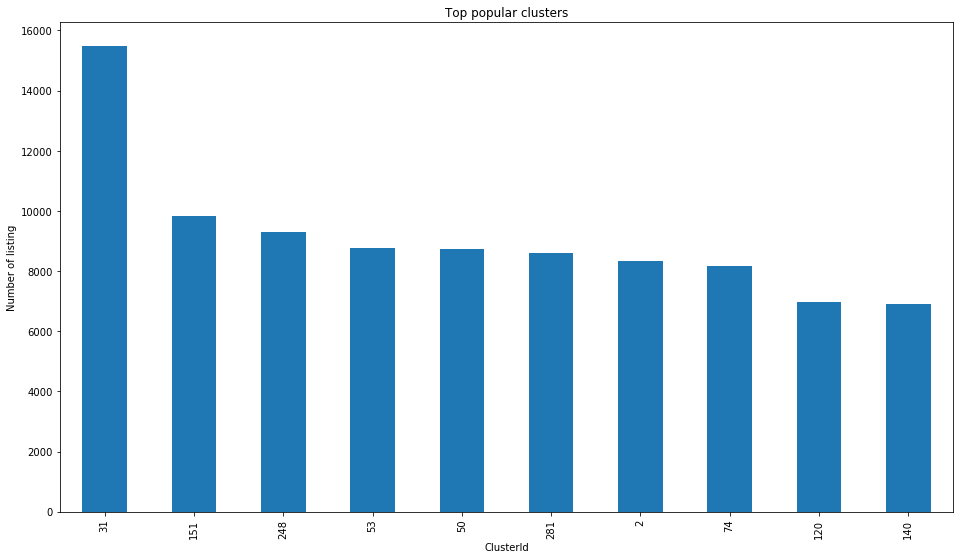

In [20]:
#Analyze label distribution of training listing products
labels = km.labels_
dfLabel = pd.DataFrame(labels)
dfLabel.columns = ['label']
dfLabel['label'].value_counts().head(10).plot(title = 'Top popular clusters', kind='bar', figsize=(16, 9))
plt.xlabel('ClusterId')
plt.ylabel('Number of listing')
plt.show()

In [22]:
#Analyze centroids and keywords
terms = vectorizer.get_feature_names()
for i in range(0,100):
    print "Cluster %d:" % i
    for ind in order_centroids[i, :5]:
        print ' %s' % terms[ind]
    print()

Cluster 0:
 conquest
 toyota
 bakki
 car
 vehicl
()
Cluster 1:
 wendi
 decor
 furnitur
 garden
 home
()
Cluster 2:
 bakki
 car
 vehicl
 daewoo
 motor
()
Cluster 3:
 laptop
 hp
 comput
 electron
 unknown
()
Cluster 4:
 offic
 busi
 equip
 furnitur
 unknown
()
Cluster 5:
 sport
 tabl
 outdoor
 equip
 pool
()
Cluster 6:
 hous
 flat
 properti
 sale
 unknown
()
Cluster 7:
 sport
 driver
 outdoor
 equip
 golf
()
Cluster 8:
 scooter
 sale
 vehicl
 bike
 helmet
()
Cluster 9:
 thatch
 construct
 improv
 servic
 roof
()
Cluster 10:
 vintag
 collect
 rare
 item
 hobbi
()
Cluster 11:
 tv
 hd
 visual
 audio
 comput
()
Cluster 12:
 beauti
 peruvian
 brazilian
 cosmet
 health
()
Cluster 13:
 babi
 cot
 pram
 kid
 equip
()
Cluster 14:
 appl
 iphon
 phone
 comput
 electron
()
Cluster 15:
 tool
 gener
 diy
 garden
 home
()
Cluster 16:
 livestock
 industri
 unknown
 brahman
 chicken
()
Cluster 17:
 trailer
 vehicl
 sale
 venter
 sprite
()
Cluster 18:
 golf
 volkswagen
 bakki
 car
 vehicl
()
Cluster 19:
 

# 5. Discussion

By examinating popular clusters, it is shown that, data show some  clusters like toyota, volkswagen ... related to car/vehicle. However, more steps are required in processing the product's content and choosing number of clusters. Otherwise, clustering are not much more helpful comparing with deviding products by their category. 

 Unseen data can be predicted to existed cluster because trained clustering model and vectorized model are saved.

This approach is very basic. There are rooms for improvement such as:

- processing text: extract product name and product attributes
- taking into account semantic meaning of the title and description (some kinds of document to vector models) 